In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
k = 5          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 783952 and U = 799789 and k = 5


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [9]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [10]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1724 rows, 1355 columns and 6985 nonzeros
Model fingerprint: 0xa3b26382
Variable types: 390 continuous, 965 integer (965 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 5 rows and 5 columns
Presolve time: 0.02s
Presolved: 1719 rows, 1350 columns, 6945 nonzeros
Variable types: 390 continuous, 960 integer (960 binary)

Root relaxation: objective 4.000000e+00, 651 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.00000    0  324          -    5.00000      -     -    0s
     0     0    5.75769    0  421          -    5.75769      -     -    0s
 

 179797 60547   37.68518   37  259   40.00000   31.69268  20.8%   114  365s
 183170 61307   34.99695   34  185   40.00000   31.72872  20.7%   113  370s
 185543 61879   38.12435   37  229   40.00000   31.75763  20.6%   113  375s
 188860 62657     cutoff   39        40.00000   31.80098  20.5%   113  380s
 191402 63295   38.50558   28  277   40.00000   31.83245  20.4%   113  385s
 195570 63967   36.50821   34  310   40.00000   31.87979  20.3%   113  390s
 198649 64714   36.73782   34  278   40.00000   31.91614  20.2%   113  395s
 201698 65530     cutoff   40        40.00000   31.95365  20.1%   112  400s
 205108 66215   37.99614   38  240   40.00000   31.98898  20.0%   112  405s
 208514 67017   37.30401   28  289   40.00000   32.02927  19.9%   112  410s
 212756 67938   36.59755   33  312   40.00000   32.07761  19.8%   112  416s
 215913 68579     cutoff   37        40.00000   32.11113  19.7%   111  421s
 218096 69042   38.11672   34  252   40.00000   32.13512  19.7%   111  426s
 220663 6956

 589777 83366     cutoff   34        39.00000   34.98164  10.3%  99.3  900s
 594313 82856   35.80083   36  265   39.00000   35.00921  10.2%  99.2  905s
 598779 82340   36.76859   33  243   39.00000   35.03977  10.2%  99.1  910s
 603113 81827   37.11222   41  281   39.00000   35.06734  10.1%  99.0  915s
 608047 81159   36.59212   37  241   39.00000   35.10329  10.0%  98.8  920s
 612708 80547   36.22872   37  215   39.00000   35.13535  9.91%  98.7  925s
 618059 79820   37.77438   41  222   39.00000   35.16872  9.82%  98.5  930s
 623244 78985     cutoff   36        39.00000   35.20348  9.73%  98.4  935s
 627214 78303     cutoff   51        39.00000   35.23238  9.66%  98.3  940s
 631695 77685   36.16743   34  205   39.00000   35.26367  9.58%  98.2  945s
 636493 76811     cutoff   40        39.00000   35.29577  9.50%  98.1  950s
 641166 76030   37.44488   33  288   39.00000   35.32910  9.41%  97.9  955s
 646313 75193     cutoff   34        39.00000   35.36431  9.32%  97.8  960s
 651728 7424

In [11]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 39.0
District 0 has population 791126 and contains counties ['Washita', 'Jackson', 'Major', 'Custer', 'Ellis', 'Comanche', 'Beckham', 'Tillman', 'Logan', 'Pawnee', 'Beaver', 'Dewey', 'Roger Mills', 'Texas', 'Woodward', 'Kingfisher', 'Grant', 'Payne', 'Cimarron', 'Garfield', 'Canadian', 'Harper', 'Alfalfa', 'Caddo', 'Greer', 'Woods', 'Harmon', 'Kay', 'Blaine', 'Kiowa', 'Noble']

District 1 has population 796292 and contains counties ['Oklahoma']

District 2 has population 786851 and contains counties ['Osage', 'Tulsa', 'Creek']

District 3 has population 791184 and contains counties ['Delaware', 'Pushmataha', 'Wagoner', 'Craig', 'Cherokee', 'Pittsburg', 'Le Flore', 'Choctaw', 'Latimer', 'McIntosh', 'Nowata', 'Haskell', 'Adair', 'Sequoyah', 'Hughes', 'Muskogee', 'Ottawa', 'Rogers', 'Mayes', 'Coal', 'McCurtain', 'Atoka', 'Okmulgee', 'Washington']

District 4 has population 793900 and contains counties ['Johnston', 'Cleveland', 'Garvin', 'Jefferson', 'Okfuskee', 

In [12]:
# To solve the MIP faster, let's fix some district roots:

r[6,0].LB = 1  # Fix Oklahoma County as root of district 0
r[34,1].LB = 1 # Fix Tulsa County as root of district 1
r[8,2].LB = 1  # Fix Comanche County as root of district 2

m.reset()      # Force Gurobi to start solving 'from scratch'
m.optimize()

Discarded solution information
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1724 rows, 1355 columns and 6985 nonzeros
Model fingerprint: 0xa68f3122
Variable types: 390 continuous, 965 integer (965 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 521 rows and 353 columns
Presolve time: 0.01s
Presolved: 1203 rows, 1002 columns, 4943 nonzeros
Variable types: 380 continuous, 622 integer (622 binary)

Root relaxation: objective 1.632442e+01, 932 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   16.32442    0  315          -   16.32442      -     -    0s
     0     0   17.92189    0  256        

In [13]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 39.0
District 0 has population 796292 and contains counties ['Oklahoma']

District 1 has population 794029 and contains counties ['Osage', 'Pawnee', 'Tulsa', 'Washington', 'Noble']

District 2 has population 786173 and contains counties ['Washita', 'Jackson', 'Major', 'Custer', 'Ellis', 'Comanche', 'Beckham', 'Tillman', 'Logan', 'Beaver', 'Dewey', 'Roger Mills', 'Texas', 'Woodward', 'Stephens', 'Kingfisher', 'Grant', 'Grady', 'Cimarron', 'Garfield', 'Canadian', 'Harper', 'Alfalfa', 'Caddo', 'Greer', 'Cotton', 'Woods', 'Harmon', 'Kay', 'Blaine', 'Kiowa']

District 3 has population 795074 and contains counties ['Delaware', 'Wagoner', 'Craig', 'Cherokee', 'Okfuskee', 'Le Flore', 'McIntosh', 'Nowata', 'Haskell', 'Payne', 'Adair', 'Sequoyah', 'Lincoln', 'Muskogee', 'Ottawa', 'Rogers', 'Mayes', 'Okmulgee', 'Creek']

District 4 has population 787785 and contains counties ['Johnston', 'Pushmataha', 'Cleveland', 'Garvin', 'Pittsburg', 'Jefferson', 'McClain', 'Choctaw'

In [14]:
# Let's draw it on a map
import geopandas as gpd

In [15]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

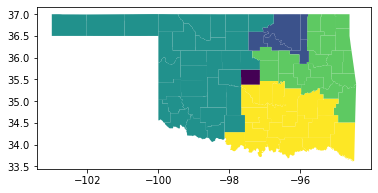

In [16]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()